# Artificial Intelligence Nanodegree

## Convolutional Neural Networks

## Project: Write an Algorithm for a Dog Identification App 

---

In this notebook, some template code has already been provided for you, and you will need to implement additional functionality to successfully complete this project. You will not need to modify the included code beyond what is requested. Sections that begin with **'(IMPLEMENTATION)'** in the header indicate that the following block of code will require additional functionality which you must provide. Instructions will be provided for each section, and the specifics of the implementation are marked in the code block with a 'TODO' statement. Please be sure to read the instructions carefully! 

> **Note**: Once you have completed all of the code implementations, you need to finalize your work by exporting the iPython Notebook as an HTML document. Before exporting the notebook to html, all of the code cells need to have been run so that reviewers can see the final implementation and output. You can then export the notebook by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.

In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a **'Question X'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.

>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut.  Markdown cells can be edited by double-clicking the cell to enter edit mode.

The rubric contains _optional_ "Stand Out Suggestions" for enhancing the project beyond the minimum requirements. If you decide to pursue the "Stand Out Suggestions", you should include the code in this IPython notebook.



---
### Why We're Here 

In this notebook, you will make the first steps towards developing an algorithm that could be used as part of a mobile or web app.  At the end of this project, your code will accept any user-supplied image as input.  If a dog is detected in the image, it will provide an estimate of the dog's breed.  If a human is detected, it will provide an estimate of the dog breed that is most resembling.  The image below displays potential sample output of your finished project (... but we expect that each student's algorithm will behave differently!). 

![Sample Dog Output](images/sample_dog_output.png)

In this real-world setting, you will need to piece together a series of models to perform different tasks; for instance, the algorithm that detects humans in an image will be different from the CNN that infers dog breed.  There are many points of possible failure, and no perfect algorithm exists.  Your imperfect solution will nonetheless create a fun user experience!

### The Road Ahead

We break the notebook into separate steps.  Feel free to use the links below to navigate the notebook.

* [Step 0](#step0): Import Datasets
* [Step 1](#step1): Detect Humans
* [Step 2](#step2): Detect Dogs
* [Step 3](#step3): Create a CNN to Classify Dog Breeds (from Scratch)
* [Step 4](#step4): Use a CNN to Classify Dog Breeds (using Transfer Learning)
* [Step 5](#step5): Create a CNN to Classify Dog Breeds (using Transfer Learning)
* [Step 6](#step6): Write your Algorithm
* [Step 7](#step7): Test Your Algorithm

---
<a id='step0'></a>
## Step 0: Import Datasets

### Import Dog Dataset

In the code cell below, we import a dataset of dog images.  We populate a few variables through the use of the `load_files` function from the scikit-learn library:
- `train_files`, `valid_files`, `test_files` - numpy arrays containing file paths to images
- `train_targets`, `valid_targets`, `test_targets` - numpy arrays containing onehot-encoded classification labels 
- `dog_names` - list of string-valued dog breed names for translating labels

In [1]:
from sklearn.datasets import load_files       
from keras.utils import np_utils
import numpy as np
from glob import glob

# define function to load train, test, and validation datasets
def load_dataset(path):
    data = load_files(path)
    dog_files = np.array(data['filenames'])
    dog_targets = np_utils.to_categorical(np.array(data['target']), 133)
    return dog_files, dog_targets

# load train, test, and validation datasets
train_files, train_targets = load_dataset('dogImages/train')
valid_files, valid_targets = load_dataset('dogImages/valid')
test_files, test_targets = load_dataset('dogImages/test')

# load list of dog names
dog_names = [item[20:-1] for item in sorted(glob("dogImages/train/*/"))]

# print statistics about the dataset
print('There are %d total dog categories.' % len(dog_names))
print('There are %s total dog images.\n' % len(np.hstack([train_files, valid_files, test_files])))
print('There are %d training dog images.' % len(train_files))
print('There are %d validation dog images.' % len(valid_files))
print('There are %d test dog images.'% len(test_files))

Using TensorFlow backend.


There are 133 total dog categories.
There are 8351 total dog images.

There are 6680 training dog images.
There are 835 validation dog images.
There are 836 test dog images.


### Import Human Dataset

In the code cell below, we import a dataset of human images, where the file paths are stored in the numpy array `human_files`.

In [2]:
import random
random.seed(8675309)

# load filenames in shuffled human dataset
human_files = np.array(glob("lfw/*/*"))
random.shuffle(human_files)

# print statistics about the dataset
print('There are %d total human images.' % len(human_files))

There are 13233 total human images.


---
<a id='step1'></a>
## Step 1: Detect Humans

We use OpenCV's implementation of [Haar feature-based cascade classifiers](http://docs.opencv.org/trunk/d7/d8b/tutorial_py_face_detection.html) to detect human faces in images.  OpenCV provides many pre-trained face detectors, stored as XML files on [github](https://github.com/opencv/opencv/tree/master/data/haarcascades).  We have downloaded one of these detectors and stored it in the `haarcascades` directory.

In the next code cell, we demonstrate how to use this detector to find human faces in a sample image.

Number of faces detected: 1


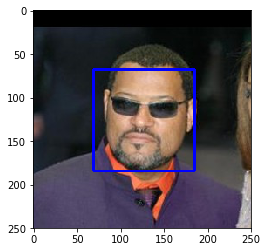

In [7]:
import cv2                
import matplotlib.pyplot as plt                        
%matplotlib inline                               

# extract pre-trained face detector
face_cascade = cv2.CascadeClassifier('haarcascades/haarcascade_frontalface_alt.xml')

# load color (BGR) image
img = cv2.imread(human_files[3])
# convert BGR image to grayscale
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# find faces in image
faces = face_cascade.detectMultiScale(gray)

# print number of faces detected in the image
print('Number of faces detected:', len(faces))

# get bounding box for each detected face
for (x,y,w,h) in faces:
    # add bounding box to color image
    cv2.rectangle(img,(x,y),(x+w,y+h),(255,0,0),2)
    
# convert BGR image to RGB for plotting
cv_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# display the image, along with bounding box
plt.imshow(cv_rgb)
plt.show()

Before using any of the face detectors, it is standard procedure to convert the images to grayscale.  The `detectMultiScale` function executes the classifier stored in `face_cascade` and takes the grayscale image as a parameter.  

In the above code, `faces` is a numpy array of detected faces, where each row corresponds to a detected face.  Each detected face is a 1D array with four entries that specifies the bounding box of the detected face.  The first two entries in the array (extracted in the above code as `x` and `y`) specify the horizontal and vertical positions of the top left corner of the bounding box.  The last two entries in the array (extracted here as `w` and `h`) specify the width and height of the box.

### Write a Human Face Detector

We can use this procedure to write a function that returns `True` if a human face is detected in an image and `False` otherwise.  This function, aptly named `face_detector`, takes a string-valued file path to an image as input and appears in the code block below.

In [8]:
# returns "True" if face is detected in image stored at img_path
def face_detector(img_path):
    img = cv2.imread(img_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray)
    return len(faces) > 0

In [9]:
# returns "True" if face is detected in image stored at img_path
def face_detector2(img_path):
    img = cv2.imread(img_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray,scaleFactor=1.2)
    return len(faces) > 0

### (IMPLEMENTATION) Assess the Human Face Detector

__Question 1:__ Use the code cell below to test the performance of the `face_detector` function.  
- What percentage of the first 100 images in `human_files` have a detected human face?  
- What percentage of the first 100 images in `dog_files` have a detected human face? 

Ideally, we would like 100% of human images with a detected face and 0% of dog images with a detected face.  You will see that our algorithm falls short of this goal, but still gives acceptable performance.  We extract the file paths for the first 100 images from each of the datasets and store them in the numpy arrays `human_files_short` and `dog_files_short`.

__Answer:__ 

From the OpenCV face detector, i got the following accuracy:

human correct = 99%

dog correct (not human) = 89 %



I created 2 more human face detectors:



    1  --  The first one was a small modification to the OpenCV, just add a scaleFactor=1.2, this increased the accuracy of the OpenCV to:


        human correct = 99%

        dog correct (not human) = 95 %




    2 --  I implemented a Binary Classification Deep CNN for human detection.  I got the following accuracy:



        Accuracy using human_test_files: 100.0 %

        Accuracy using (dog) test_files: 100.0 %

        human correct = 100.0 %

        dog correct(not human) =  98.0 %



In [10]:
human_files_short = human_files[:100]
dog_files_short = train_files[:100]
# Do NOT modify the code above this line.

## TODO: Test the performance of the face_detector algorithm 
## on the images in human_files_short and dog_files_short.

human_detection=100*sum(1 for face in human_files_short if face_detector(face))/len(human_files_short)
dog_detection=100*(1-sum(1 for dogface in dog_files_short if face_detector(dogface))/len(dog_files_short))

print("human correct %=",human_detection)
print("dog correct %=",dog_detection)

human correct %= 99.0
dog correct %= 89.0


__Question 2:__ This algorithmic choice necessitates that we communicate to the user that we accept human images only when they provide a clear view of a face (otherwise, we risk having unneccessarily frustrated users!). In your opinion, is this a reasonable expectation to pose on the user? If not, can you think of a way to detect humans in images that does not necessitate an image with a clearly presented face?

__Answer:__

I think in general, given the advancement in Deep Learning, it is a somewhat unreasonable expectation to limit the choices to only 'clear' views of uploaded face images.  If we are providing a face detection service, it should allow for the broadest case technologically possible. It may be better to utilize more complex face detection, and give a suggestion to users that the results would be better if clear faces are used, but it should not be a strict requirement.  In some cases it may be acceptable to limit the usage of the input images the user is allowed to input, such as when the face is to be also used as a profile picture.  For this project we are providing both a human face detector and dog face detector, which makes it reasonable, but a clear face requirement would limit the funcationality the users can experience overall.

It would be much better to allow accepting any image, and run that through another more robust system, such as a Deep CNN, and predict the % likelyhood of the image being a face or not.  If we follow this path we achieve both the ability to upload faces, the original requirements, as well as allowing for expanded functionality, which is overall a better user experience.

A binary classification Deep CNN was created for face/dog detection, with the following accuracies:


        Accuracy using human_test_files: 100.0 %

        Accuracy using (dog) test_files: 100.0 %

        human correct = 100.0 %

        dog correct(not human) =  98.0 %
        
        

In [11]:
## (Optional) TODO: Report the performance of another  
## face detection algorithm on the LFW dataset
### Feel free to use as many code cells as needed.
human_detection=100*sum(1 for face in human_files_short if face_detector2(face))/len(human_files_short)
dog_detection=100*(1-sum(1 for dogface in dog_files_short if face_detector2(dogface))/len(dog_files_short))

print("human correct %=",human_detection)
print("dog correct %=",dog_detection)

human correct %= 99.0
dog correct %= 95.0


## CNN For Dog/Human Detection

### Create list of tensors for dog/human CNN


In [9]:
from keras.preprocessing import image                  
from tqdm import tqdm
from PIL import ImageFile                            
ImageFile.LOAD_TRUNCATED_IMAGES = True                 


def path_to_tensor(img_path):
    # loads RGB image as PIL.Image.Image type
    img = image.load_img(img_path, target_size=(224, 224))
    # convert PIL.Image.Image type to 3D tensor with shape (224, 224, 3)
    x = image.img_to_array(img)
    # convert 3D tensor to 4D tensor with shape (1, 224, 224, 3) and return 4D tensor
    return np.expand_dims(x, axis=0)

def paths_to_tensor(img_paths):
    list_of_tensors = [path_to_tensor(img_path) for img_path in tqdm(img_paths)]
    return np.vstack(list_of_tensors)



### Create data and labels for CNN binary classification

In [10]:
human_train_files=human_files[:len(train_files)]
human_test_files=human_files[len(train_files)+1:len(train_files)+len(test_files)+1]

dog_label_vectors=np.zeros(len(train_files))
dog_label_test=np.zeros(len(test_files))
human_label_vectors=np.ones(len(human_train_files))
human_label_test=np.ones(len(human_test_files))

train_tensors_files=np.concatenate((train_files,human_train_files))
test_tensors_files=np.concatenate((test_files,human_test_files))

train_labels=np.concatenate([dog_label_vectors,human_label_vectors])
test_labels=np.concatenate([dog_label_test,human_label_test])

print("final train images:",len(train_tensors_files))
print("final train labels:",len(train_labels))

print("final test images:",len(test_tensors_files))
print("final test labels:",len(test_labels))

print("train_tensors_shape:",train_tensors_files.shape)

#train_labels2 = np.array([0] * len(trin_dog_tensors) + [1] * len(train_human_tensors))
                                   
train_tensors = paths_to_tensor(train_tensors_files).astype('float32')/255
test_tensors = paths_to_tensor(test_tensors_files).astype('float32')/255

final train images: 13360
final train labels: 13360
final test images: 1672
final test labels: 1672
train_tensors_shape: (13360,)


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1672/1672 [00:44<00:00, 20.32it/s]


### Create binary human CNN model 

In [11]:
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, BatchNormalization, Activation
from keras.layers import Dropout, Flatten, Dense
from keras.models import Sequential

# 100%,100%,100%,98%
human_model = Sequential()
human_model.add(Conv2D(filters=16, kernel_size=2, padding='same', activation='relu',input_shape=(224, 224, 3)))
human_model.add(MaxPooling2D(pool_size=2))
human_model.add(Conv2D(filters=32, kernel_size=3,padding='same', activation='relu'))
human_model.add(MaxPooling2D(pool_size=2))
human_model.add(Conv2D(filters=64, kernel_size=3, padding='same', activation='relu'))
human_model.add(MaxPooling2D(pool_size=2))
human_model.add(Conv2D(filters=128, kernel_size=2,padding='same', activation='relu'))
human_model.add(MaxPooling2D(pool_size=2))
human_model.add(Conv2D(filters=266, kernel_size=2, padding='same', activation='relu'))
human_model.add(GlobalAveragePooling2D(data_format='channels_last'))
human_model.add(Dense(500, activation='relu'))
human_model.add(Dense(500, activation='relu'))
human_model.add(Dense(1, activation='sigmoid'))

human_model.summary()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 224, 224, 16)      208       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 112, 112, 16)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 112, 112, 32)      4640      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 56, 56, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 56, 56, 64)        18496     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 28, 28, 64)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 28, 28, 128)       32896     
__________

In [12]:
from keras.optimizers import RMSprop
rmsprop_optimizer=RMSprop(lr=0.0001)
human_model.compile(optimizer=rmsprop_optimizer,
                    loss='binary_crossentropy',
                    metrics=['accuracy'])

In [13]:
from keras.callbacks import ReduceLROnPlateau,EarlyStopping, ModelCheckpoint
from keras.models import load_model

load_trained_model=True
epochs = 100
early_stopping = EarlyStopping(monitor='val_loss', patience=11)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1,
                              patience=2,  verbose=1)

checkpointer = ModelCheckpoint(filepath='saved_models/human_weights.best.from_scratch.hdf5', 
                               verbose=1, save_best_only=True)

if load_trained_model:
    human_model=load_model("human_or_dog.h5")
else:
    human_model.fit(train_tensors, train_labels,
              validation_split=0.10,
              shuffle=True,
              epochs=epochs, batch_size=100, callbacks=[checkpointer,early_stopping], verbose=2)

In [46]:
human_model.load_weights('saved_models/human_weights.best.from_scratch.hdf5')

### Uses CNN to detect if human in image

In [14]:
# returns "True" if face is detected in image stored at img_path
def face_detector3(img_path):
    imgrs = path_to_tensor(img_path=img_path)
    faces = human_model.predict(imgrs)
    faces = faces[0][0]
    return (faces > 0.5)

### Tests for human images in the following datasets:
1) test set of human images

2) test set of dog images

3) human_files_short dataset

4) dog_files_short dataset


In [15]:
human_detection=100*sum(1 for face in human_test_files[:100] if face_detector3(face))/len(human_test_files[:100])
dog_detection=100*(1-sum(1 for dogface in test_files[:100] if face_detector3(dogface))/len(test_files[:100]))

print("Accuracy of human_test_files:",human_detection)
print("Accuracy of (dog) test_files:",dog_detection)

human_detection=100*sum(1 for face in human_files_short if face_detector3(face))/len(human_files_short)
dog_detection=100*(1-sum(1 for dogface in dog_files_short if face_detector3(dogface))/len(dog_files_short))

print("Accuracy of human_files_short:",human_detection)
print("Accuracy of dog_files_short:",dog_detection)

Accuracy of human_test_files: 100.0
Accuracy of (dog) test_files: 100.0
Accuracy of human_files_short: 100.0
Accuracy of dog_files_short: 98.0


In [402]:
#human_model.save('human_or_dog.h5')

---
<a id='step2'></a>
## Step 2: Detect Dogs

In this section, we use a pre-trained [ResNet-50](http://ethereon.github.io/netscope/#/gist/db945b393d40bfa26006) model to detect dogs in images.  Our first line of code downloads the ResNet-50 model, along with weights that have been trained on [ImageNet](http://www.image-net.org/), a very large, very popular dataset used for image classification and other vision tasks.  ImageNet contains over 10 million URLs, each linking to an image containing an object from one of [1000 categories](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a).  Given an image, this pre-trained ResNet-50 model returns a prediction (derived from the available categories in ImageNet) for the object that is contained in the image.

In [12]:
from keras.applications.resnet50 import ResNet50

# define ResNet50 model
ResNet50_model = ResNet50(weights='imagenet')

### Pre-process the Data

When using TensorFlow as backend, Keras CNNs require a 4D array (which we'll also refer to as a 4D tensor) as input, with shape

$$
(\text{nb_samples}, \text{rows}, \text{columns}, \text{channels}),
$$

where `nb_samples` corresponds to the total number of images (or samples), and `rows`, `columns`, and `channels` correspond to the number of rows, columns, and channels for each image, respectively.  

The `path_to_tensor` function below takes a string-valued file path to a color image as input and returns a 4D tensor suitable for supplying to a Keras CNN.  The function first loads the image and resizes it to a square image that is $224 \times 224$ pixels.  Next, the image is converted to an array, which is then resized to a 4D tensor.  In this case, since we are working with color images, each image has three channels.  Likewise, since we are processing a single image (or sample), the returned tensor will always have shape

$$
(1, 224, 224, 3).
$$

The `paths_to_tensor` function takes a numpy array of string-valued image paths as input and returns a 4D tensor with shape 

$$
(\text{nb_samples}, 224, 224, 3).
$$

Here, `nb_samples` is the number of samples, or number of images, in the supplied array of image paths.  It is best to think of `nb_samples` as the number of 3D tensors (where each 3D tensor corresponds to a different image) in your dataset!

In [13]:
from keras.preprocessing import image                  
from tqdm import tqdm

def path_to_tensor(img_path):
    # loads RGB image as PIL.Image.Image type
    img = image.load_img(img_path, target_size=(224, 224))
    # convert PIL.Image.Image type to 3D tensor with shape (224, 224, 3)
    x = image.img_to_array(img)
    # convert 3D tensor to 4D tensor with shape (1, 224, 224, 3) and return 4D tensor
    return np.expand_dims(x, axis=0)

def paths_to_tensor(img_paths):
    list_of_tensors = [path_to_tensor(img_path) for img_path in tqdm(img_paths)]
    return np.vstack(list_of_tensors)


### Making Predictions with ResNet-50

Getting the 4D tensor ready for ResNet-50, and for any other pre-trained model in Keras, requires some additional processing.  First, the RGB image is converted to BGR by reordering the channels.  All pre-trained models have the additional normalization step that the mean pixel (expressed in RGB as $[103.939, 116.779, 123.68]$ and calculated from all pixels in all images in ImageNet) must be subtracted from every pixel in each image.  This is implemented in the imported function `preprocess_input`.  If you're curious, you can check the code for `preprocess_input` [here](https://github.com/fchollet/keras/blob/master/keras/applications/imagenet_utils.py).

Now that we have a way to format our image for supplying to ResNet-50, we are now ready to use the model to extract the predictions.  This is accomplished with the `predict` method, which returns an array whose $i$-th entry is the model's predicted probability that the image belongs to the $i$-th ImageNet category.  This is implemented in the `ResNet50_predict_labels` function below.

By taking the argmax of the predicted probability vector, we obtain an integer corresponding to the model's predicted object class, which we can identify with an object category through the use of this [dictionary](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a). 

In [14]:
from keras.applications.resnet50 import preprocess_input, decode_predictions

def ResNet50_predict_labels(img_path):
    # returns prediction vector for image located at img_path
    img = preprocess_input(path_to_tensor(img_path))
    return np.argmax(ResNet50_model.predict(img))

### Write a Dog Detector

While looking at the [dictionary](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a), you will notice that the categories corresponding to dogs appear in an uninterrupted sequence and correspond to dictionary keys 151-268, inclusive, to include all categories from `'Chihuahua'` to `'Mexican hairless'`.  Thus, in order to check to see if an image is predicted to contain a dog by the pre-trained ResNet-50 model, we need only check if the `ResNet50_predict_labels` function above returns a value between 151 and 268 (inclusive).

We use these ideas to complete the `dog_detector` function below, which returns `True` if a dog is detected in an image (and `False` if not).

In [15]:
### returns "True" if a dog is detected in the image stored at img_path
def dog_detector(img_path):
    prediction = ResNet50_predict_labels(img_path)
    return ((prediction <= 268) & (prediction >= 151))

### (IMPLEMENTATION) Assess the Dog Detector

__Question 3:__ Use the code cell below to test the performance of your `dog_detector` function.  
- What percentage of the images in `human_files_short` have a detected dog?  
- What percentage of the images in `dog_files_short` have a detected dog?

__Answer:__ 

1% have detected a dog in human images (99% accuracy)

100% have detected a dog in dog images

In [16]:
### TODO: Test the performance of the dog_detector function
### on the images in human_files_short and dog_files_short.

human_detection=100.*(1-sum(1 for face in human_files_short if dog_detector(face))/len(human_files_short))
dog_detection=100.*(sum(1 for dogface in dog_files_short if dog_detector(dogface))/len(dog_files_short))
print("Accuracy of humans not detected in dog images:",(human_detection))
print("Accuracy of dogs detected in dog images:",(dog_detection))


Accuracy of humans not detected in dog images: 99.0
Accuracy of dogs detected in dog images: 100.0


---
<a id='step3'></a>
## Step 3: Create a CNN to Classify Dog Breeds (from Scratch)

Now that we have functions for detecting humans and dogs in images, we need a way to predict breed from images.  In this step, you will create a CNN that classifies dog breeds.  You must create your CNN _from scratch_ (so, you can't use transfer learning _yet_!), and you must attain a test accuracy of at least 1%.  In Step 5 of this notebook, you will have the opportunity to use transfer learning to create a CNN that attains greatly improved accuracy.

Be careful with adding too many trainable layers!  More parameters means longer training, which means you are more likely to need a GPU to accelerate the training process.  Thankfully, Keras provides a handy estimate of the time that each epoch is likely to take; you can extrapolate this estimate to figure out how long it will take for your algorithm to train. 

We mention that the task of assigning breed to dogs from images is considered exceptionally challenging.  To see why, consider that *even a human* would have great difficulty in distinguishing between a Brittany and a Welsh Springer Spaniel.  

Brittany | Welsh Springer Spaniel
- | - 
<img src="images/Brittany_02625.jpg" width="100"> | <img src="images/Welsh_springer_spaniel_08203.jpg" width="200">

It is not difficult to find other dog breed pairs with minimal inter-class variation (for instance, Curly-Coated Retrievers and American Water Spaniels).  

Curly-Coated Retriever | American Water Spaniel
- | -
<img src="images/Curly-coated_retriever_03896.jpg" width="200"> | <img src="images/American_water_spaniel_00648.jpg" width="200">


Likewise, recall that labradors come in yellow, chocolate, and black.  Your vision-based algorithm will have to conquer this high intra-class variation to determine how to classify all of these different shades as the same breed.  

Yellow Labrador | Chocolate Labrador | Black Labrador
- | -
<img src="images/Labrador_retriever_06457.jpg" width="150"> | <img src="images/Labrador_retriever_06455.jpg" width="240"> | <img src="images/Labrador_retriever_06449.jpg" width="220">

We also mention that random chance presents an exceptionally low bar: setting aside the fact that the classes are slightly imabalanced, a random guess will provide a correct answer roughly 1 in 133 times, which corresponds to an accuracy of less than 1%.  

Remember that the practice is far ahead of the theory in deep learning.  Experiment with many different architectures, and trust your intuition.  And, of course, have fun! 

### Pre-process the Data

We rescale the images by dividing every pixel in every image by 255.

In [17]:
from PIL import ImageFile                            
ImageFile.LOAD_TRUNCATED_IMAGES = True                 

# pre-process the data for Keras
train_tensors = paths_to_tensor(train_files).astype('float32')/255
valid_tensors = paths_to_tensor(valid_files).astype('float32')/255
test_tensors = paths_to_tensor(test_files).astype('float32')/255

100%|████████████████████████████████████████████████████████████████████████████████████████████████| 836/836 [00:07<00:00, 113.41it/s]


### (IMPLEMENTATION) Model Architecture

Create a CNN to classify dog breed.  At the end of your code cell block, summarize the layers of your model by executing the line:
    
        model.summary()

We have imported some Python modules to get you started, but feel free to import as many modules as you need.  If you end up getting stuck, here's a hint that specifies a model that trains relatively fast on CPU and attains >1% test accuracy in 5 epochs:

![Sample CNN](images/sample_cnn.png)
           
__Question 4:__ Outline the steps you took to get to your final CNN architecture and your reasoning at each step.  If you chose to use the hinted architecture above, describe why you think that CNN architecture should work well for the image classification task.

__Answer:__ 

There were several iterations to create a decent architecture.  Initially I started with a basic CNN, no batchnormalization,  dropout, and only a few Conv2d layers.  I know that deeper architectures can handle more complex images, so I started increasing the depth of the network.  Increasing the depth of the network increases the likelyhood of getting a vanishing gradient.

To compensate for vanishing gradient, I implemeneted BatchNormalization, which normalizes the gradients so that very small numbers are boosted, and very large numbers are reduced.  Batch normalization, with Keras should be aligned to the axis with the channls, in this case axis=3, and applied to all layers.

Larger networks also hava a tendency to memorize the dataset as opposed to a generalized smooth prediction.  To compensate for this, Dropout was applied, and was most effective on the final fully connected portion of the CNN.

Additionally, the training uses both augmented images as well as raw images, in a hybrid training process of looping the training over augmented images, then raw images.  This was very effective for increasing the accuracy.

Further implementations, not implemented, of a better CNN would be to utilize the keras api , not sequential, network model.  This would allow for creating more advanced architectures, including a full Resnet50 type model.  An approach that I beleive would be very accurate would be to create a mini-Resnet50 type architecture, including shortcut levels, but not having as many levels as the full-blown Resnet50 model.

In [42]:
### TODO: Define your architecture.
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, BatchNormalization, Activation
from keras.layers import Dropout, Flatten, Dense,Input
from keras.layers.advanced_activations import LeakyReLU
from keras.models import Sequential
from keras import regularizers

# input_img = Input(shape=(224, 224, 3)) # used for keras api model

### TODO: Define your architecture.
scratch_cnn_model = Sequential()
scratch_cnn_model.add(Conv2D(kernel_initializer='he_normal',kernel_regularizer=regularizers.l2(0.001),
                 input_shape=(224, 224, 3),
                 filters=16, kernel_size=2, padding='same', activation=None))
scratch_cnn_model.add(BatchNormalization(axis=3))
# scratch_cnn_model.add(LeakyReLU(alpha=.3))
scratch_cnn_model.add(Activation('relu'))
scratch_cnn_model.add(MaxPooling2D(pool_size=2,strides=(1,1)))
scratch_cnn_model.add(Conv2D(kernel_initializer='he_normal',kernel_regularizer=regularizers.l2(0.001),
                 filters=32, kernel_size=2, padding='same', activation=None))
scratch_cnn_model.add(BatchNormalization(axis=3))
# scratch_cnn_model.add(LeakyReLU(alpha=.3))
scratch_cnn_model.add(Activation('relu'))
scratch_cnn_model.add(MaxPooling2D(pool_size=2,strides=(1,1)))
scratch_cnn_model.add(Conv2D(kernel_initializer='he_normal',kernel_regularizer=regularizers.l2(0.001),
                 filters=64, kernel_size=3,strides=(2,2), padding='same', activation=None))
scratch_cnn_model.add(BatchNormalization(axis=3))
# scratch_cnn_model.add(LeakyReLU(alpha=.3))
scratch_cnn_model.add(Activation('relu'))
scratch_cnn_model.add(MaxPooling2D(pool_size=3,strides=(2,2)))
scratch_cnn_model.add(Conv2D(kernel_initializer='he_normal',kernel_regularizer=regularizers.l2(0.001),
                 filters=133, kernel_size=3,strides=(2,2), padding='same', activation=None))
scratch_cnn_model.add(BatchNormalization(axis=3))
# scratch_cnn_model.add(LeakyReLU(alpha=.3))
scratch_cnn_model.add(Activation('relu'))
scratch_cnn_model.add(Conv2D(kernel_initializer='he_normal',kernel_regularizer=regularizers.l2(0.001),
                 filters=133, kernel_size=3,strides=(2,2), padding='same', activation='relu'),)
scratch_cnn_model.add(BatchNormalization(axis=3))
# scratch_cnn_model.add(LeakyReLU(alpha=.3))
scratch_cnn_model.add(Activation('relu'))
scratch_cnn_model.add(GlobalAveragePooling2D(data_format='channels_last'))
scratch_cnn_model.add(Dense(1000, activation=None,kernel_regularizer=regularizers.l2(0.001)))
# scratch_cnn_model.add(LeakyReLU(alpha=.3))
scratch_cnn_model.add(Activation('relu'))
scratch_cnn_model.add(Dropout(0.6))
scratch_cnn_model.add(Dense(133, activation='softmax'))
scratch_cnn_model.summary()



# 52.39 3 training runs
# scratch_cnn_model = Sequential()
# scratch_cnn_model.add(Conv2D(kernel_initializer='he_normal',
#                  input_shape=(224, 224, 3),
#                  filters=16, kernel_size=2, padding='same', activation=None))
# scratch_cnn_model.add(BatchNormalization(axis=3))
# # scratch_cnn_model.add(LeakyReLU(alpha=.3))
# scratch_cnn_model.add(Activation('relu'))
# scratch_cnn_model.add(MaxPooling2D(pool_size=2,strides=(1,1)))
# scratch_cnn_model.add(Conv2D(kernel_initializer='he_normal',
#                  filters=32, kernel_size=2, padding='same', activation=None))
# scratch_cnn_model.add(BatchNormalization(axis=3))
# # scratch_cnn_model.add(LeakyReLU(alpha=.3))
# scratch_cnn_model.add(Activation('relu'))
# scratch_cnn_model.add(MaxPooling2D(pool_size=2,strides=(1,1)))
# scratch_cnn_model.add(Conv2D(kernel_initializer='he_normal',#kernel_regularizer=regularizers.l2(0.01),
#                  filters=64, kernel_size=3,strides=(2,2), padding='same', activation=None))
# scratch_cnn_model.add(BatchNormalization(axis=3))
# # scratch_cnn_model.add(LeakyReLU(alpha=.3))
# scratch_cnn_model.add(Activation('relu'))
# scratch_cnn_model.add(MaxPooling2D(pool_size=3,strides=(2,2)))
# scratch_cnn_model.add(Conv2D(kernel_initializer='he_normal',#kernel_regularizer=regularizers.l2(0.01),
#                  filters=133, kernel_size=3,strides=(2,2), padding='same', activation=None))
# scratch_cnn_model.add(BatchNormalization(axis=3))
# # scratch_cnn_model.add(LeakyReLU(alpha=.3))
# scratch_cnn_model.add(Activation('relu'))
# scratch_cnn_model.add(Conv2D(kernel_initializer='he_normal',kernel_regularizer=regularizers.l2(0.001),
#                  filters=133, kernel_size=3,strides=(2,2), padding='same', activation='relu'),)
# scratch_cnn_model.add(BatchNormalization(axis=3))
# # scratch_cnn_model.add(LeakyReLU(alpha=.3))
# scratch_cnn_model.add(Activation('relu'))
# scratch_cnn_model.add(GlobalAveragePooling2D(data_format='channels_last'))
# scratch_cnn_model.add(Dense(768, activation=None,kernel_regularizer=regularizers.l2(0.001)))
# # scratch_cnn_model.add(LeakyReLU(alpha=.3))
# scratch_cnn_model.add(Activation('relu'))
# scratch_cnn_model.add(Dropout(0.6))
# scratch_cnn_model.add(Dense(133, activation='softmax'))
# scratch_cnn_model.summary()





# scratch_cnn_model = Sequential()
# scratch_cnn_model.add(Conv2D(kernel_initializer='he_normal',
#                  input_shape=(224, 224, 3),
#                  filters=16, kernel_size=2, padding='same', activation=None))
# scratch_cnn_model.add(BatchNormalization(axis=3))
# scratch_cnn_model.add(Activation('relu'))
# scratch_cnn_model.add(MaxPooling2D(pool_size=2,strides=(1,1)))
# scratch_cnn_model.add(Conv2D(kernel_initializer='he_normal',
#                  filters=32, kernel_size=2, padding='same', activation=None))
# scratch_cnn_model.add(BatchNormalization(axis=3))
# scratch_cnn_model.add(Activation('relu'))
# scratch_cnn_model.add(MaxPooling2D(pool_size=2,strides=(1,1)))
# scratch_cnn_model.add(Conv2D(kernel_initializer='he_normal',
#                  filters=64, kernel_size=3,strides=(2,2), padding='same', activation=None))
# scratch_cnn_model.add(BatchNormalization(axis=3))
# scratch_cnn_model.add(Activation('relu'))
# scratch_cnn_model.add(MaxPooling2D(pool_size=3,strides=(2,2)))
# scratch_cnn_model.add(Conv2D(kernel_initializer='he_normal',
#                  filters=133, kernel_size=3,strides=(2,2), padding='same', activation=None))
# scratch_cnn_model.add(BatchNormalization(axis=3))
# scratch_cnn_model.add(Activation('relu'))
# scratch_cnn_model.add(Conv2D(kernel_initializer='he_normal',
#                  filters=133, kernel_size=3,strides=(2,2), padding='same', activation='relu'),)
# scratch_cnn_model.add(BatchNormalization(axis=3))
# scratch_cnn_model.add(Activation('relu'))
# scratch_cnn_model.add(GlobalAveragePooling2D(data_format='channels_last'))
# scratch_cnn_model.add(Dense(768, activation='relu'))
# scratch_cnn_model.add(Dropout(0.6))
# scratch_cnn_model.add(Dense(133, activation='softmax'))
# scratch_cnn_model.summary()



_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 224, 224, 16)      208       
_________________________________________________________________
batch_normalization_6 (Batch (None, 224, 224, 16)      64        
_________________________________________________________________
activation_56 (Activation)   (None, 224, 224, 16)      0         
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 223, 223, 16)      0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 223, 223, 32)      2080      
_________________________________________________________________
batch_normalization_7 (Batch (None, 223, 223, 32)      128       
_________________________________________________________________
activation_57 (Activation)   (None, 223, 223, 32)      0         
__________

#### Alternate Scratch CNN Model Attempts

In [ ]:


# 41.2 % , augmented hybrid
#
# model = Sequential()
# input_img = Input(shape=(224, 224, 3))
# ### TODO: Define your architecture.
# model = Sequential()
# model.add(Conv2D(kernel_initializer='he_normal',
#                  input_shape=(224, 224, 3),
#                  filters=16, kernel_size=2, padding='same', activation=None))
# model.add(BatchNormalization(axis=3))
# model.add(Activation('relu'))
# model.add(MaxPooling2D(pool_size=2,strides=(1,1)))
# model.add(Conv2D(kernel_initializer='he_normal',
#                  filters=32, kernel_size=2, padding='same', activation=None))
# model.add(BatchNormalization(axis=3))
# model.add(Activation('relu'))
# model.add(MaxPooling2D(pool_size=2,strides=(1,1)))
# model.add(Conv2D(kernel_initializer='he_normal',
#                  filters=64, kernel_size=3,strides=(2,2), padding='same', activation=None))
# model.add(BatchNormalization(axis=3))
# model.add(Activation('relu'))
# model.add(MaxPooling2D(pool_size=3,strides=(2,2)))
# model.add(Conv2D(kernel_initializer='he_normal',
#                  filters=133, kernel_size=3,strides=(2,2), padding='same', activation=None))
# model.add(BatchNormalization(axis=3))
# model.add(Activation('relu'))
# model.add(Conv2D(kernel_initializer='he_normal',
#                  filters=133, kernel_size=3,strides=(2,2), padding='same', activation='relu'),)
# model.add(BatchNormalization(axis=3))
# model.add(Activation('relu'))
# model.add(GlobalAveragePooling2D(data_format='channels_last'))
# model.add(Dense(768, activation='relu'))
# model.add(Dropout(0.6))
# model.add(Dense(133, activation='softmax'))
# model.summary()


# 17 %
# model = Sequential()
# model.add(Dropout(0.1,input_shape=(224, 224, 3)))
# model.add(Conv2D(kernel_initializer='he_normal',
#                  bias_initializer='TruncatedNormal',
#                  filters=64, kernel_size=2, padding='same', activation=None))
# model.add(Activation('relu'))
# model.add(MaxPooling2D(pool_size=2))
# model.add(Dropout(0.1))
# model.add(Conv2D(kernel_initializer='he_normal',
#                  bias_initializer='TruncatedNormal',
#                  filters=128, kernel_size=2, padding='same', activation=None))
# model.add(Activation('relu'))
# model.add(MaxPooling2D(pool_size=2))
# model.add(Dropout(0.2))
# model.add(Conv2D(kernel_initializer='he_normal',
#                  bias_initializer='TruncatedNormal',
#                  filters=128, kernel_size=2, padding='same', activation=None))
# # model.add(BatchNormalization(axis=1))
# model.add(Activation('relu'))
# model.add(Dropout(0.2))
# model.add(MaxPooling2D(pool_size=2))
# model.add(Conv2D(kernel_initializer='he_normal',
#                  bias_initializer='TruncatedNormal',
#                  filters=256, kernel_size=2, padding='same', activation=None))
# # model.add(BatchNormalization(axis=1))
# model.add(Activation('relu'))
# model.add(Dropout(0.2))
# model.add(Conv2D(kernel_initializer='he_normal',
#                  bias_initializer='TruncatedNormal',
#                  filters=500, kernel_size=2, padding='same', activation='relu'))
# model.add(Activation('relu'))
# model.add(Dropout(0.3))
# model.add(GlobalAveragePooling2D(data_format='channels_last'))
# model.add(Dense(133, activation='softmax'))
# model.summary()


# 23% , 26.6% w/augmentation
# model = Sequential()
# ### TODO: Define your architecture.
# model = Sequential()
# model.add(Conv2D(kernel_initializer='he_normal',
#                  bias_initializer='TruncatedNormal',
#                  filters=64, kernel_size=2, padding='same', activation=None,input_shape=(224, 224, 3)))
# model.add(Activation('relu'))
# model.add(MaxPooling2D(pool_size=2))
# model.add(Conv2D(kernel_initializer='he_normal',
#                  bias_initializer='TruncatedNormal',
#                  filters=128, kernel_size=2, padding='same', activation=None))
# model.add(Activation('relu'))
# model.add(MaxPooling2D(pool_size=2))
# model.add(Conv2D(kernel_initializer='he_normal',
#                  bias_initializer='TruncatedNormal',
#                  filters=128, kernel_size=2, padding='same', activation=None))
# model.add(Activation('relu'))
# model.add(MaxPooling2D(pool_size=2))
# model.add(Conv2D(kernel_initializer='he_normal',
#                  bias_initializer='TruncatedNormal',
#                  filters=256, kernel_size=2, padding='same', activation=None))
# model.add(Activation('relu'))
# model.add(Conv2D(kernel_initializer='he_normal',
#                  bias_initializer='TruncatedNormal',
#                  filters=500, kernel_size=2, padding='same', activation='relu'))
# model.add(Activation('relu'))
# model.add(GlobalAveragePooling2D(data_format='channels_last'))
# model.add(Dense(133, activation='softmax'))
# model.summary()



# 20.993 % 33% w/augmentation
### TODO: Define your architecture.
# model = Sequential()
# model.add(Conv2D(filters=16, kernel_size=2, padding='same', activation='relu',input_shape=(224, 224, 3)))
# model.add(MaxPooling2D(pool_size=2))
# model.add(Conv2D(filters=32, kernel_size=2, padding='same', activation='relu'))
# model.add(MaxPooling2D(pool_size=2))
# model.add(Conv2D(filters=64, kernel_size=2, padding='same', activation='relu'))
# model.add(MaxPooling2D(pool_size=2))
# model.add(Conv2D(filters=133, kernel_size=2, padding='same', activation='relu'))
# model.add(BatchNormalization(axis=1))
# model.add(MaxPooling2D(pool_size=2))
# model.add(Conv2D(filters=266, kernel_size=2, padding='same', activation='relu'))
# model.add(GlobalAveragePooling2D(data_format='channels_last'))
# model.add(Dense(266, activation='relu'))
# model.add(Dropout(0.2))
# model.add(Dense(133, activation='softmax'))



# 12.32 % (25 epochs)
## TODO: Define your architecture.
# model = Sequential()
# model.add(Conv2D(filters=16, kernel_size=2, padding='same', activation='relu', input_shape=(224, 224, 3)))
# model.add(MaxPooling2D(pool_size=2))
# model.add(Conv2D(filters=32, kernel_size=2, padding='same', activation='relu'))
# model.add(MaxPooling2D(pool_size=2))
# model.add(Conv2D(filters=64, kernel_size=2, padding='same', activation='relu'))
# model.add(MaxPooling2D(pool_size=2))
# model.add(Conv2D(filters=133, kernel_size=2, padding='same', activation='relu'))
# model.add(BatchNormalization(axis=1))
# model.add(MaxPooling2D(pool_size=2))
# model.add(GlobalAveragePooling2D(data_format='channels_last'))
# model.add(Dense(266, activation='relu'))
# model.add(Dense(133, activation='softmax'))


# 7.2967% (30 epochs)
### TODO: Define your architecture.
# model = Sequential()
# model.add(Conv2D(filters=16, kernel_size=2, padding='same', activation='relu', input_shape=(224, 224, 3)))
# model.add(MaxPooling2D(pool_size=2))
# model.add(Conv2D(filters=32, kernel_size=2, padding='same', activation='relu'))
# model.add(MaxPooling2D(pool_size=2))
# model.add(Conv2D(filters=64, kernel_size=2, padding='same', activation='relu'))
# model.add(MaxPooling2D(pool_size=2))
# model.add(Conv2D(filters=133, kernel_size=2, padding='same', activation='relu'))
# model.add(BatchNormalization(axis=1))
# model.add(MaxPooling2D(pool_size=2))
# model.add(GlobalAveragePooling2D(data_format='channels_last'))
# model.add(Activation('softmax'))


# 4.7%
### TODO: Define your architecture.
# model = Sequential()
# model.add(Conv2D(filters=32, kernel_size=2, padding='same', activation='relu', input_shape=(224, 224, 3)))
# model.add(MaxPooling2D(pool_size=2))
# model.add(BatchNormalization(axis=1))
# model.add(Conv2D(filters=64, kernel_size=2, padding='same', activation='relu'))
# model.add(BatchNormalization(axis=1))
# model.add(MaxPooling2D(pool_size=2))
# model.add(Conv2D(filters=256, kernel_size=2, padding='same', activation='relu'))
# model.add(MaxPooling2D(pool_size=2))
# model.add(GlobalAveragePooling2D(data_format='channels_last'))
# # model.add(Flatten())
# model.add(Dense(300, activation='relu'))
# model.add(Dense(200, activation='relu'))
# model.add(Dense(133, activation='softmax'))

### Compile the Model

In [43]:
# model.compile(optimizer=RMSprop(lr=.01), loss='categorical_crossentropy', metrics=['accuracy'])
scratch_cnn_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

### (IMPLEMENTATION) Train the Model

Train your model in the code cell below.  Use model checkpointing to save the model that attains the best validation loss.

You are welcome to [augment the training data](https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html), but this is not a requirement. 

### Augmented Data

In [22]:
from keras.preprocessing.image import ImageDataGenerator

# create and configure augmented image generator
datagen_train = ImageDataGenerator(
    shear_range=0.2, # randomly shear images  (2%)
    zoom_range=0.08, # randomly zoom images (8%)
    rotation_range=10, # randomly rotate images (10 degree range)
    width_shift_range=0.1,  # randomly shift images horizontally (10% of total width)
    height_shift_range=0.1,  # randomly shift images vertically (10% of total height)
    horizontal_flip=True) # randomly flip images horizontally

# do not generate augmented images for validation set
datagen_valid = ImageDataGenerator()

# fit augmented image generator on data
datagen_train.fit(train_tensors)
datagen_valid.fit(valid_tensors)

### Hybrid Augmented / Raw training

This training alternates between training with augmented images and then raw images
The training is done for a number of epochs on augmented training(augment_epochs) and 
trained for a number of epochs on the raw image data(non_augmented_epochs)

In [145]:
from keras.callbacks import ModelCheckpoint, EarlyStopping, LearningRateScheduler
from keras.models import load_model
from keras_tqdm import TQDMNotebookCallback
import keras.backend as K


load_cnn=False
train_cnn=True
use_augmentation=True

if load_cnn:
    scratch_cnn_model=load_model("mycnn_augmented3.h5")

if train_cnn:
    master_epochs = 300
    augment_epochs=20
    non_augment_epochs=10
    early_stopping = EarlyStopping(monitor='val_loss', patience=3)
    batch_size=100
    checkpointer = ModelCheckpoint(monitor='val_acc',filepath='saved_models/weights.best.from_scratch.hdf5', 
                               verbose=1, save_best_only=True)
    print(train_tensors.shape[0])
    total_epochs=master_epochs//(augment_epochs+non_augment_epochs)
    def scheduler(epoch):
        if epoch==0:
            print("changing learning rate to .0001")
            return .001
        return .0001
    change_lr=LearningRateScheduler(scheduler)
    
    for i in range(total_epochs):
        print("Step:",i,"of ",total_epochs-1)
        lrate=K.get_value(scratch_cnn_model.optimizer.lr)
        if (i>=0 and i<3):
            print("current learning rate:",lrate)
            K.set_value(scratch_cnn_model.optimizer.lr,0.001)
            lrate=K.get_value(scratch_cnn_model.optimizer.lr)
            print("new learning rate=",lrate)
        elif i>=3 and i<8:
            print("current learning rate:",lrate)
            K.set_value(scratch_cnn_model.optimizer.lr,0.0001)
            lrate=K.get_value(scratch_cnn_model.optimizer.lr)
            print("new learning rate=",lrate)
        else:
            print("current learning rate:",lrate)
            K.set_value(scratch_cnn_model.optimizer.lr,0.00001)
            lrate=K.get_value(scratch_cnn_model.optimizer.lr)
            print("new learning rate=",lrate)
            
        if use_augmentation:
            scratch_cnn_model.fit_generator(datagen_train.flow(train_tensors, train_targets, batch_size=batch_size),
                                steps_per_epoch=train_tensors.shape[0] // batch_size,
                                epochs=augment_epochs, verbose=2,
                                validation_data=datagen_valid.flow(valid_tensors, valid_targets, batch_size=batch_size),
                                validation_steps=valid_tensors.shape[0] // batch_size,
                                callbacks=[early_stopping,
                                           checkpointer],
#                                            ,TQDMNotebookCallback(leave_inner=True,leave_outer=True)]
#                                            ,change_lr]
                               )
        scratch_cnn_model.fit(train_tensors, train_targets, 
                  validation_data=(valid_tensors, valid_targets),
                  epochs=non_augment_epochs, batch_size=batch_size,
                  callbacks=[early_stopping,
                             checkpointer],
#                              ,TQDMNotebookCallback(leave_inner=True,leave_outer=True)],
#                              change_lr],
                  verbose=2)


6680
Step: 0 of  9
current learning rate: 0.001
new learning rate= 0.001
Epoch 1/20
Epoch 00000: val_acc improved from -inf to 0.14750, saving model to saved_models/weights.best.from_scratch.hdf5
83s - loss: 1.7724 - acc: 0.6097 - val_loss: 8.3785 - val_acc: 0.1475
Epoch 2/20
Epoch 00001: val_acc improved from 0.14750 to 0.23375, saving model to saved_models/weights.best.from_scratch.hdf5
77s - loss: 1.7247 - acc: 0.6334 - val_loss: 4.5217 - val_acc: 0.2337
Epoch 3/20
Epoch 00002: val_acc improved from 0.23375 to 0.28375, saving model to saved_models/weights.best.from_scratch.hdf5
79s - loss: 1.6614 - acc: 0.6475 - val_loss: 3.9923 - val_acc: 0.2837
Epoch 4/20
Epoch 00003: val_acc did not improve
79s - loss: 1.5954 - acc: 0.6758 - val_loss: 5.2138 - val_acc: 0.2100
Epoch 5/20
Epoch 00004: val_acc did not improve
82s - loss: 1.5632 - acc: 0.6834 - val_loss: 4.8730 - val_acc: 0.2525
Epoch 6/20
Epoch 00005: val_acc did not improve
83s - loss: 1.5435 - acc: 0.6884 - val_loss: 4.8318 - val_

Epoch 3/20
Epoch 00002: val_acc did not improve
83s - loss: 0.8606 - acc: 0.8922 - val_loss: 2.5303 - val_acc: 0.5087
Epoch 4/20
Epoch 00003: val_acc did not improve
82s - loss: 0.8545 - acc: 0.8968 - val_loss: 2.5179 - val_acc: 0.5162
Epoch 5/20
Epoch 00004: val_acc did not improve
81s - loss: 0.8498 - acc: 0.8987 - val_loss: 2.5709 - val_acc: 0.5162
Epoch 6/20
Epoch 00005: val_acc improved from 0.52500 to 0.52625, saving model to saved_models/weights.best.from_scratch.hdf5
82s - loss: 0.8607 - acc: 0.8970 - val_loss: 2.5322 - val_acc: 0.5262
Train on 6680 samples, validate on 835 samples
Epoch 1/10
Epoch 00000: val_acc did not improve
37s - loss: 0.5832 - acc: 0.9936 - val_loss: 2.4977 - val_acc: 0.5150
Epoch 2/10
Epoch 00001: val_acc did not improve
37s - loss: 0.5755 - acc: 0.9930 - val_loss: 2.4942 - val_acc: 0.5246
Epoch 3/10
Epoch 00002: val_acc did not improve
37s - loss: 0.5714 - acc: 0.9915 - val_loss: 2.5128 - val_acc: 0.5078
Epoch 4/10
Epoch 00003: val_acc did not improve
3

Epoch 4/20
Epoch 00003: val_acc did not improve
79s - loss: 0.6668 - acc: 0.9297 - val_loss: 2.3848 - val_acc: 0.5387
Epoch 5/20
Epoch 00004: val_acc did not improve
81s - loss: 0.6671 - acc: 0.9277 - val_loss: 2.3612 - val_acc: 0.5362
Train on 6680 samples, validate on 835 samples
Epoch 1/10
Epoch 00000: val_acc did not improve
37s - loss: 0.4662 - acc: 0.9946 - val_loss: 2.3781 - val_acc: 0.5341
Epoch 2/10
Epoch 00001: val_acc did not improve
37s - loss: 0.4669 - acc: 0.9954 - val_loss: 2.3805 - val_acc: 0.5365
Epoch 3/10
Epoch 00002: val_acc did not improve
38s - loss: 0.4655 - acc: 0.9954 - val_loss: 2.3759 - val_acc: 0.5329
Epoch 4/10
Epoch 00003: val_acc did not improve
38s - loss: 0.4631 - acc: 0.9955 - val_loss: 2.3772 - val_acc: 0.5341
Epoch 5/10
Epoch 00004: val_acc did not improve
38s - loss: 0.4612 - acc: 0.9973 - val_loss: 2.3762 - val_acc: 0.5353
Epoch 6/10
Epoch 00005: val_acc did not improve
38s - loss: 0.4639 - acc: 0.9945 - val_loss: 2.3833 - val_acc: 0.5293
Epoch 7/1

In [148]:
scratch_cnn_model.load_weights('saved_models/weights.best.from_scratch.hdf5')


In [149]:
# get index of predicted dog breed for each image in test set
dog_breed_predictions = [np.argmax(scratch_cnn_model.predict(np.expand_dims(tensor, axis=0))) for tensor in test_tensors]

# report test accuracy
test_accuracy = 100*np.sum(np.array(dog_breed_predictions)==np.argmax(test_targets, axis=1))/len(dog_breed_predictions)
print('CNN from scratch, Test accuracy: %.4f%%' % test_accuracy)

CNN from scratch, Test accuracy: 53.7081%


### save model for future runs

In [147]:
scratch_cnn_model.save("mycnn_augmented3.h5")

### Load complete saved model

In [51]:
 scratch_cnn_model=load_model("mycnn_augmented3.h5")

### for loading scratch cnn trained only with raw images

In [70]:
load_cnn=True
if load_cnn:
    scratch_cnn_model=load_model("mycnn.h5")

### For Scratch CNN Raw image Training  (non-Augmented images), for comparison

In [69]:
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.models import load_model

# load_cnn=True
# train_cnn=True

# if load_cnn:
#     scratch_cnn_model=load_model("mycnn.h5")

# if train_cnn:
#     epochs = 100
#     early_stopping = EarlyStopping(monitor='val_loss', patience=11)


#     checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.from_scratch.hdf5', 
#                                verbose=1, save_best_only=True)

#     scratch_cnn_model.fit(train_tensors, train_targets, 
#               validation_data=(valid_tensors, valid_targets),
#               epochs=epochs, batch_size=64, callbacks=[checkpointer,early_stopping], verbose=2)

### TODO: specify the number of epochs that you would like to use to train the model.

epochs = 100

### Do NOT modify the code below this line.
scratch_cnn_model.fit(train_tensors, train_targets, 
          validation_data=(valid_tensors, valid_targets),
          epochs=epochs, batch_size=20, callbacks=[checkpointer], verbose=1)


Train on 6680 samples, validate on 835 samples
Epoch 1/100
1280/6680 [====>.........................] - ETA: 357s - loss: 1.4301 - acc: 0.600 - ETA: 191s - loss: 1.6308 - acc: 0.525 - ETA: 135s - loss: 1.5693 - acc: 0.533 - ETA: 107s - loss: 1.5714 - acc: 0.537 - ETA: 90s - loss: 1.6949 - acc: 0.500 - ETA: 79s - loss: 1.8997 - acc: 0.47 - ETA: 71s - loss: 1.8427 - acc: 0.47 - ETA: 65s - loss: 1.7910 - acc: 0.50 - ETA: 60s - loss: 1.9161 - acc: 0.48 - ETA: 56s - loss: 1.8926 - acc: 0.49 - ETA: 53s - loss: 1.8894 - acc: 0.48 - ETA: 50s - loss: 1.8556 - acc: 0.48 - ETA: 48s - loss: 1.8050 - acc: 0.50 - ETA: 46s - loss: 1.7846 - acc: 0.50 - ETA: 44s - loss: 1.7825 - acc: 0.51 - ETA: 43s - loss: 1.7870 - acc: 0.51 - ETA: 42s - loss: 1.7442 - acc: 0.51 - ETA: 41s - loss: 1.7500 - acc: 0.51 - ETA: 39s - loss: 1.7357 - acc: 0.51 - ETA: 38s - loss: 1.7267 - acc: 0.51 - ETA: 38s - loss: 1.7188 - acc: 0.51 - ETA: 37s - loss: 1.7462 - acc: 0.50 - ETA: 36s - loss: 1.7467 - acc: 0.50 - ETA: 35s - lo

KeyboardInterrupt: 

### Load the Model with the Best Validation Loss

In [113]:
scratch_cnn_model.load_weights('saved_models/weights.best.from_scratch.hdf5')

### Test the Model

Try out your model on the test dataset of dog images.  Ensure that your test accuracy is greater than 1%.

In [72]:
# get index of predicted dog breed for each image in test set
dog_breed_predictions = [np.argmax(scratch_cnn_model.predict(np.expand_dims(tensor, axis=0))) for tensor in test_tensors]

# report test accuracy
test_accuracy = 100*np.sum(np.array(dog_breed_predictions)==np.argmax(test_targets, axis=1))/len(dog_breed_predictions)
print('Scratch CNN trained w/o augmentation, Test accuracy: %.4f%%' % test_accuracy)

Scratch CNN trained w/o augmentation, Test accuracy: 22.0096%


In [132]:
model.save("mycnn.h5")

---
<a id='step4'></a>
## Step 4: Use a CNN to Classify Dog Breeds

To reduce training time without sacrificing accuracy, we show you how to train a CNN using transfer learning.  In the following step, you will get a chance to use transfer learning to train your own CNN.

### Obtain Bottleneck Features

In [73]:
bottleneck_features = np.load('bottleneck_features/DogVGG16Data.npz')
train_VGG16 = bottleneck_features['train']
valid_VGG16 = bottleneck_features['valid']
test_VGG16 = bottleneck_features['test']

### Model Architecture

The model uses the the pre-trained VGG-16 model as a fixed feature extractor, where the last convolutional output of VGG-16 is fed as input to our model.  We only add a global average pooling layer and a fully connected layer, where the latter contains one node for each dog category and is equipped with a softmax.

In [74]:
VGG16_model = Sequential()
VGG16_model.add(GlobalAveragePooling2D(input_shape=train_VGG16.shape[1:]))
VGG16_model.add(Dense(133, activation='softmax'))

VGG16_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
global_average_pooling2d_6 ( (None, 512)               0         
_________________________________________________________________
dense_15 (Dense)             (None, 133)               68229     
Total params: 68,229.0
Trainable params: 68,229.0
Non-trainable params: 0.0
_________________________________________________________________


### Compile the Model

In [76]:
VGG16_model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

### Train the Model

In [77]:
checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.VGG16.hdf5', 
                               verbose=1, save_best_only=True)

VGG16_model.fit(train_VGG16, train_targets, 
          validation_data=(valid_VGG16, valid_targets),
          epochs=20, batch_size=20, callbacks=[checkpointer], verbose=1)

Train on 6680 samples, validate on 835 samples
Epoch 1/20
6680/6680 [==============================] - 4s - loss: 12.3261 - acc: 0.1295 - val_loss: 10.9364 - val_acc: 0.2096
Epoch 2/20
6680/6680 [==============================] - 2s - loss: 10.4254 - acc: 0.2771 - val_loss: 10.3366 - val_acc: 0.2826
Epoch 3/20
6680/6680 [==============================] - 2s - loss: 9.9298 - acc: 0.3355 - val_loss: 10.0893 - val_acc: 0.3198
Epoch 4/20
6680/6680 [==============================] - 2s - loss: 9.7508 - acc: 0.3641 - val_loss: 10.1114 - val_acc: 0.3138
Epoch 5/20
6680/6680 [==============================] - 2s - loss: 9.6052 - acc: 0.3756 - val_loss: 9.7992 - val_acc: 0.3377
Epoch 6/20
6680/6680 [==============================] - 2s - loss: 9.1644 - acc: 0.4027 - val_loss: 9.4916 - val_acc: 0.3521
Epoch 7/20


6680/6680 [==============================] - 2s - loss: 8.9872 - acc: 0.4229 - val_loss: 9.4424 - val_acc: 0.3581
Epoch 8/20
6680/6680 [==============================] - 2s - loss: 8.9425 - acc: 0.4325 - val_loss: 9.4193 - val_acc: 0.3605
Epoch 9/20
6680/6680 [==============================] - 2s - loss: 8.9183 - acc: 0.4383 - val_loss: 9.3823 - val_acc: 0.3713
Epoch 10/20
6680/6680 [==============================] - 2s - loss: 8.7734 - acc: 0.4455 - val_loss: 9.2918 - val_acc: 0.3749
Epoch 11/20
6680/6680 [==============================] - 2s - loss: 8.7087 - acc: 0.4521 - val_loss: 9.2074 - val_acc: 0.3916
Epoch 12/20
6680/6680 [==============================] - 2s - loss: 8.6297 - acc: 0.4590 - val_loss: 9.1360 - val_acc: 0.3904
Epoch 13/20


6680/6680 [==============================] - 2s - loss: 8.5582 - acc: 0.4641 - val_loss: 8.9851 - val_acc: 0.4000
Epoch 14/20
6680/6680 [==============================] - 2s - loss: 8.4568 - acc: 0.4680 - val_loss: 8.8883 - val_acc: 0.4024
Epoch 15/20
6680/6680 [==============================] - 2s - loss: 8.3663 - acc: 0.4726 - val_loss: 8.9176 - val_acc: 0.3988
Epoch 16/20
6680/6680 [==============================] - 2s - loss: 8.3154 - acc: 0.4775 - val_loss: 8.8485 - val_acc: 0.4012
Epoch 17/20
6680/6680 [==============================] - 2s - loss: 8.2993 - acc: 0.4817 - val_loss: 8.8083 - val_acc: 0.4120
Epoch 18/20
6680/6680 [==============================] - 2s - loss: 8.2228 - acc: 0.4825 - val_loss: 8.8407 - val_acc: 0.4024
Epoch 19/20


6680/6680 [==============================] - 2s - loss: 8.0914 - acc: 0.4877 - val_loss: 8.6951 - val_acc: 0.4156
Epoch 20/20
6680/6680 [==============================] - 2s - loss: 7.9647 - acc: 0.4993 - val_loss: 8.5760 - val_acc: 0.4180


### Load the Model with the Best Validation Loss

In [78]:
VGG16_model.load_weights('saved_models/weights.best.VGG16.hdf5')

### Test the Model

Now, we can use the CNN to test how well it identifies breed within our test dataset of dog images.  We print the test accuracy below.

In [79]:
# get index of predicted dog breed for each image in test set
VGG16_predictions = [np.argmax(VGG16_model.predict(np.expand_dims(feature, axis=0))) for feature in test_VGG16]

# report test accuracy
test_accuracy = 100*np.sum(np.array(VGG16_predictions)==np.argmax(test_targets, axis=1))/len(VGG16_predictions)
print('VGG16 model, Test accuracy: %.4f%%' % test_accuracy)

VGG16 model, Test accuracy: 40.5502%


### Predict Dog Breed with the Model

In [80]:
from extract_bottleneck_features import *

def VGG16_predict_breed(img_path):
    # extract bottleneck features
    bottleneck_feature = extract_VGG16(path_to_tensor(img_path))
    # obtain predicted vector
    predicted_vector = VGG16_model.predict(bottleneck_feature)
    # return dog breed that is predicted by the model
    return dog_names[np.argmax(predicted_vector)]

---
<a id='step5'></a>
## Step 5: Create a CNN to Classify Dog Breeds (using Transfer Learning)

You will now use transfer learning to create a CNN that can identify dog breed from images.  Your CNN must attain at least 60% accuracy on the test set.

In Step 4, we used transfer learning to create a CNN using VGG-16 bottleneck features.  In this section, you must use the bottleneck features from a different pre-trained model.  To make things easier for you, we have pre-computed the features for all of the networks that are currently available in Keras:
- [VGG-19](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/DogVGG19Data.npz) bottleneck features
- [ResNet-50](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/DogResnet50Data.npz) bottleneck features
- [Inception](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/DogInceptionV3Data.npz) bottleneck features
- [Xception](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/DogXceptionData.npz) bottleneck features

The files are encoded as such:

    Dog{network}Data.npz
    
where `{network}`, in the above filename, can be one of `VGG19`, `Resnet50`, `InceptionV3`, or `Xception`.  Pick one of the above architectures, download the corresponding bottleneck features, and store the downloaded file in the `bottleneck_features/` folder in the repository.

### (IMPLEMENTATION) Obtain Bottleneck Features

In the code block below, extract the bottleneck features corresponding to the train, test, and validation sets by running the following:

    bottleneck_features = np.load('bottleneck_features/Dog{network}Data.npz')
    train_{network} = bottleneck_features['train']
    valid_{network} = bottleneck_features['valid']
    test_{network} = bottleneck_features['test']

In [55]:
### TODO: Obtain bottleneck features from another pre-trained CNN.
my_bottleneck_features = np.load('bottleneck_features/DogResnet50Data.npz')
my_train_ResNet50 = my_bottleneck_features['train']
my_valid_ResNet50 = my_bottleneck_features['valid']
my_test_ResNet50 = my_bottleneck_features['test']

### (IMPLEMENTATION) Model Architecture

Create a CNN to classify dog breed.  At the end of your code cell block, summarize the layers of your model by executing the line:
    
        <your model's name>.summary()
   
__Question 5:__ Outline the steps you took to get to your final CNN architecture and your reasoning at each step.  Describe why you think the architecture is suitable for the current problem.

__Answer:__ 

Using a pretrained CNN is different than a CNN from scratch.  Initially attempts were made to add additional Convolutional layers on top of the Resnet model, but the results were not as good as just adding Densly connected layers to the end of the resnet model.  This is most likely because the pre trained resnet50 model was trained on images that are similar to the dog classification images I used for my training.  The maximum accuraccy obtained using the pretrained resnet50 as a base, was 86%.  I could not achieve a higher accuracy, likely because of limitations of the pretrained resnet50 model.

Various sizes and depth networks were tried, including no networks, single small dense networks, small deep networks, and large networks.

The optimal solution involved adding a dropout to the beginning of the network, which randomly ignores some of the original features at each ephoch.  This increases the training focus range.  

Additionally, Using 2 very large Dense networks, both with high dropout, avoids memorization, and equally distributes the gradients across a broader range of nodes in the fully connected layers.  This creates a normalized attention to various segments of the images linked to their respective activated features.


Training was modified to allow 'resetting' the network to a network that has not diverged from decent test accuracy too much.  This means that training was done in a loop, with early_stopping, and then the network was reset to the most recent set of good weights, and then training resumed.

Learning rate reduction was utilized, and this works better when an initially lower learning rate is compiled into the optimizer (.0001).  This increases training time only slightly, but offers a smoother training, avoiding training overshooting.  




In [139]:
### TODO: Define your architecture.


my_ResNet50_model = Sequential()
my_ResNet50_model.add(Dropout(.2,input_shape=my_train_ResNet50.shape[1:]))
my_ResNet50_model.add(GlobalAveragePooling2D())
my_ResNet50_model.add(Dense(2000, activation='relu',kernel_regularizer=regularizers.l2(0.0001)))
my_ResNet50_model.add(Dropout(.55))
my_ResNet50_model.add(Dense(2000, activation='relu',kernel_regularizer=regularizers.l2(0.001)))
my_ResNet50_model.add(Dropout(.55))
my_ResNet50_model.add(Dense(133, activation='softmax'))

my_ResNet50_model.summary()



_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dropout_27 (Dropout)         (None, 1, 1, 2048)        0         
_________________________________________________________________
global_average_pooling2d_11  (None, 2048)              0         
_________________________________________________________________
dense_29 (Dense)             (None, 2000)              4098000   
_________________________________________________________________
dropout_28 (Dropout)         (None, 2000)              0         
_________________________________________________________________
dense_30 (Dense)             (None, 2000)              4002000   
_________________________________________________________________
dropout_29 (Dropout)         (None, 2000)              0         
_________________________________________________________________
dense_31 (Dense)             (None, 133)               266133    
Total para

### Additional Model attempts

In [123]:

# 84.92
# my_ResNet50_model = Sequential()
# my_ResNet50_model.add(GlobalAveragePooling2D(input_shape=my_train_ResNet50.shape[1:]))
# my_ResNet50_model.add(Dense(4000,kernel_initializer='he_normal', activation='relu'))
# my_ResNet50_model.add(Dropout(.65))
# my_ResNet50_model.add(Dense(133,kernel_initializer='he_normal', activation='softmax'))

# my_ResNet50_model.summary()


# 84.8
# my_ResNet50_model = Sequential()
# my_ResNet50_model.add(GlobalAveragePooling2D(input_shape=my_train_ResNet50.shape[1:]))
# my_ResNet50_model.add(Dense(3000, activation='relu'))
# my_ResNet50_model.add(Dropout(.8))
# my_ResNet50_model.add(Dense(133, activation='softmax'))

# my_ResNet50_model.summary()


# 84.4 
# my_ResNet50_model = Sequential()
# my_ResNet50_model.add(GlobalAveragePooling2D(input_shape=my_train_ResNet50.shape[1:]))
# my_ResNet50_model.add(Dense(3000, activation='relu'))
# my_ResNet50_model.add(Dropout(.8))
# my_ResNet50_model.add(Dense(133, activation='softmax'))

# my_ResNet50_model.summary()

# 84.3
# my_ResNet50_model = Sequential()
# my_ResNet50_model.add(GlobalAveragePooling2D(input_shape=my_train_ResNet50.shape[1:]))
# my_ResNet50_model.add(Dense(500,activation='relu'))
# my_ResNet50_model.add(Dropout(.7))
# my_ResNet50_model.add(Dense(133, activation='softmax'))
# my_ResNet50_model.summary()

# 83
# my_ResNet50_model.add(GlobalAveragePooling2D(input_shape=my_train_ResNet50.shape[1:]))
# my_ResNet50_model.add(Dense(1000, activation='relu'))
# my_ResNet50_model.add(Dropout(.5))
# my_ResNet50_model.add(Dense(500, activation='relu'))
# my_ResNet50_model.add(Dropout(.3))
# my_ResNet50_model.add(Dense(266, activation='relu'))
# my_ResNet50_model.add(Dropout(.2))
# my_ResNet50_model.add(Dense(133, activation='softmax'))

# my_ResNet50_model.summary()

#81.3%
# my_ResNet50_model = Sequential()
# my_ResNet50_model.add(GlobalAveragePooling2D(input_shape=my_train_ResNet50.shape[1:]))
# my_ResNet50_model.add(Dense(133, activation='softmax'))
# my_ResNet50_model.summary()


### (IMPLEMENTATION) Compile the Model

In [140]:
### TODO: Compile the model.
from keras.optimizers import RMSprop
# my_ResNet50_model.compile(loss='categorical_crossentropy', optimizer=RMSprop(lr=.00001), metrics=['accuracy'])
my_ResNet50_model.compile(loss='categorical_crossentropy', optimizer=RMSprop(lr=.0001), metrics=['accuracy'])

### (IMPLEMENTATION) Train the Model

Train your model in the code cell below.  Use model checkpointing to save the model that attains the best validation loss.  

You are welcome to [augment the training data](https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html), but this is not a requirement. 

In [141]:
### TODO: Train the model.
from keras.callbacks import ReduceLROnPlateau,EarlyStopping, ModelCheckpoint
from keras.models import load_model
import keras.backend as K

load_trained_model=False
train_model=True
reset_lr=True

if load_trained_model:
    my_ResNet50_model=load_model("resnet50mod.h5")

if reset_lr:
    K.set_value(my_ResNet50_model.optimizer.lr,0.0001)

    
if train_model:
    early_stopping = EarlyStopping(monitor='val_loss', patience=20)
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.001,
                                  patience=15,  verbose=1)
    checkpointer = ModelCheckpoint(monitor='val_loss',filepath='saved_models/weights.best.ResNet50v3.hdf5', 
                                   verbose=1, save_best_only=True)

    my_ResNet50_model.fit(my_train_ResNet50, train_targets, 
              validation_data=(my_valid_ResNet50, valid_targets),
              epochs=800, batch_size=300, callbacks=[checkpointer,
#                                                      TQDMNotebookCallback(leave_inner=True,leave_outer=True),
                                                     early_stopping,reduce_lr], verbose=2)
    for i in range(4):
        my_ResNet50_model.load_weights('saved_models/weights.best.ResNet50v3.hdf5')
        early_stopping = EarlyStopping(monitor='val_loss', patience=10)
        reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.001,
                                      patience=5,  verbose=1)
        checkpointer = ModelCheckpoint(monitor='val_loss',filepath='saved_models/weights.best.ResNet50v3.hdf5', 
                                       verbose=1, save_best_only=True)

        my_ResNet50_model.fit(my_train_ResNet50, train_targets, 
                  validation_data=(my_valid_ResNet50, valid_targets),
                  epochs=800, batch_size=300, callbacks=[checkpointer,
#                                                          TQDMNotebookCallback(leave_inner=True,leave_outer=True),
                                                         early_stopping,reduce_lr], verbose=2)



Train on 6680 samples, validate on 835 samples
Epoch 1/800
Epoch 00000: val_loss improved from inf to 6.21989, saving model to saved_models/weights.best.ResNet50v3.hdf5
3s - loss: 7.0960 - acc: 0.0338 - val_loss: 6.2199 - val_acc: 0.3844
Epoch 2/800
Epoch 00001: val_loss improved from 6.21989 to 5.40614, saving model to saved_models/weights.best.ResNet50v3.hdf5
0s - loss: 6.2775 - acc: 0.1334 - val_loss: 5.4061 - val_acc: 0.5150
Epoch 3/800
Epoch 00002: val_loss improved from 5.40614 to 4.50656, saving model to saved_models/weights.best.ResNet50v3.hdf5
0s - loss: 5.5664 - acc: 0.2525 - val_loss: 4.5066 - val_acc: 0.5772
Epoch 4/800
Epoch 00003: val_loss improved from 4.50656 to 3.85936, saving model to saved_models/weights.best.ResNet50v3.hdf5
0s - loss: 4.9379 - acc: 0.3476 - val_loss: 3.8594 - val_acc: 0.6515
Epoch 5/800
Epoch 00004: val_loss improved from 3.85936 to 3.47253, saving model to saved_models/weights.best.ResNet50v3.hdf5
0s - loss: 4.4496 - acc: 0.4278 - val_loss: 3.4725 

Epoch 00041: val_loss improved from 2.11125 to 2.09312, saving model to saved_models/weights.best.ResNet50v3.hdf5
0s - loss: 1.9105 - acc: 0.9003 - val_loss: 2.0931 - val_acc: 0.8419
Epoch 43/800
Epoch 00042: val_loss improved from 2.09312 to 2.08231, saving model to saved_models/weights.best.ResNet50v3.hdf5
0s - loss: 1.8651 - acc: 0.9073 - val_loss: 2.0823 - val_acc: 0.8455
Epoch 44/800
Epoch 00043: val_loss improved from 2.08231 to 2.07324, saving model to saved_models/weights.best.ResNet50v3.hdf5
0s - loss: 1.8454 - acc: 0.9084 - val_loss: 2.0732 - val_acc: 0.8419
Epoch 45/800
Epoch 00044: val_loss improved from 2.07324 to 2.04652, saving model to saved_models/weights.best.ResNet50v3.hdf5
0s - loss: 1.8271 - acc: 0.9112 - val_loss: 2.0465 - val_acc: 0.8371
Epoch 46/800
Epoch 00045: val_loss improved from 2.04652 to 2.03606, saving model to saved_models/weights.best.ResNet50v3.hdf5
0s - loss: 1.7998 - acc: 0.9144 - val_loss: 2.0361 - val_acc: 0.8479
Epoch 47/800
Epoch 00046: val_los

Epoch 85/800
Epoch 00084: val_loss did not improve
0s - loss: 1.0376 - acc: 0.9665 - val_loss: 1.4460 - val_acc: 0.8587
Epoch 86/800
Epoch 00085: val_loss improved from 1.44514 to 1.41445, saving model to saved_models/weights.best.ResNet50v3.hdf5
0s - loss: 1.0252 - acc: 0.9686 - val_loss: 1.4144 - val_acc: 0.8587
Epoch 87/800
Epoch 00086: val_loss improved from 1.41445 to 1.40770, saving model to saved_models/weights.best.ResNet50v3.hdf5
0s - loss: 1.0023 - acc: 0.9696 - val_loss: 1.4077 - val_acc: 0.8611
Epoch 88/800
Epoch 00087: val_loss did not improve
0s - loss: 0.9957 - acc: 0.9677 - val_loss: 1.4148 - val_acc: 0.8503
Epoch 89/800
Epoch 00088: val_loss improved from 1.40770 to 1.38138, saving model to saved_models/weights.best.ResNet50v3.hdf5
0s - loss: 0.9785 - acc: 0.9707 - val_loss: 1.3814 - val_acc: 0.8503
Epoch 90/800
Epoch 00089: val_loss did not improve
0s - loss: 0.9553 - acc: 0.9741 - val_loss: 1.3840 - val_acc: 0.8551
Epoch 91/800
Epoch 00090: val_loss improved from 1.3

Epoch 00132: val_loss improved from 0.97137 to 0.96120, saving model to saved_models/weights.best.ResNet50v3.hdf5
0s - loss: 0.5183 - acc: 0.9840 - val_loss: 0.9612 - val_acc: 0.8587
Epoch 134/800
Epoch 00133: val_loss did not improve
0s - loss: 0.5097 - acc: 0.9853 - val_loss: 0.9689 - val_acc: 0.8527
Epoch 135/800
Epoch 00134: val_loss did not improve
0s - loss: 0.5067 - acc: 0.9855 - val_loss: 0.9701 - val_acc: 0.8587
Epoch 136/800
Epoch 00135: val_loss improved from 0.96120 to 0.94349, saving model to saved_models/weights.best.ResNet50v3.hdf5
0s - loss: 0.4991 - acc: 0.9850 - val_loss: 0.9435 - val_acc: 0.8587
Epoch 137/800
Epoch 00136: val_loss did not improve
0s - loss: 0.4924 - acc: 0.9855 - val_loss: 0.9568 - val_acc: 0.8539
Epoch 138/800
Epoch 00137: val_loss improved from 0.94349 to 0.93742, saving model to saved_models/weights.best.ResNet50v3.hdf5
0s - loss: 0.4790 - acc: 0.9885 - val_loss: 0.9374 - val_acc: 0.8575
Epoch 139/800
Epoch 00138: val_loss did not improve
0s - los

Epoch 186/800
Epoch 00185: val_loss improved from 0.75395 to 0.75358, saving model to saved_models/weights.best.ResNet50v3.hdf5
0s - loss: 0.2943 - acc: 0.9901 - val_loss: 0.7536 - val_acc: 0.8539
Epoch 187/800
Epoch 00186: val_loss improved from 0.75358 to 0.74381, saving model to saved_models/weights.best.ResNet50v3.hdf5
0s - loss: 0.2934 - acc: 0.9894 - val_loss: 0.7438 - val_acc: 0.8563
Epoch 188/800
Epoch 00187: val_loss did not improve
0s - loss: 0.2860 - acc: 0.9915 - val_loss: 0.7681 - val_acc: 0.8563
Epoch 189/800
Epoch 00188: val_loss did not improve
0s - loss: 0.2833 - acc: 0.9907 - val_loss: 0.7490 - val_acc: 0.8563
Epoch 190/800
Epoch 00189: val_loss did not improve
0s - loss: 0.2832 - acc: 0.9904 - val_loss: 0.7529 - val_acc: 0.8503
Epoch 191/800
Epoch 00190: val_loss improved from 0.74381 to 0.74193, saving model to saved_models/weights.best.ResNet50v3.hdf5
0s - loss: 0.2812 - acc: 0.9901 - val_loss: 0.7419 - val_acc: 0.8587
Epoch 192/800
Epoch 00191: val_loss did not im

Epoch 245/800
Epoch 00244: val_loss did not improve
0s - loss: 0.2021 - acc: 0.9927 - val_loss: 0.6965 - val_acc: 0.8599
Epoch 246/800
Epoch 00245: val_loss did not improve
0s - loss: 0.2041 - acc: 0.9925 - val_loss: 0.6753 - val_acc: 0.8587
Epoch 247/800
Epoch 00246: val_loss did not improve
0s - loss: 0.2023 - acc: 0.9909 - val_loss: 0.6864 - val_acc: 0.8455
Epoch 248/800
Epoch 00247: val_loss did not improve
0s - loss: 0.1982 - acc: 0.9927 - val_loss: 0.6660 - val_acc: 0.8575
Epoch 249/800
Epoch 00248: val_loss did not improve
0s - loss: 0.1981 - acc: 0.9939 - val_loss: 0.6676 - val_acc: 0.8599
Epoch 250/800
Epoch 00249: val_loss did not improve
0s - loss: 0.1971 - acc: 0.9931 - val_loss: 0.6790 - val_acc: 0.8467
Epoch 251/800
Epoch 00250: val_loss did not improve
0s - loss: 0.1983 - acc: 0.9919 - val_loss: 0.6754 - val_acc: 0.8515
Epoch 252/800
Epoch 00251: val_loss did not improve
0s - loss: 0.1959 - acc: 0.9922 - val_loss: 0.6617 - val_acc: 0.8539
Epoch 253/800
Epoch 00252: val_l

Epoch 32/800
Epoch 00031: val_loss improved from 0.65247 to 0.65237, saving model to saved_models/weights.best.ResNet50v3.hdf5
0s - loss: 0.2051 - acc: 0.9937 - val_loss: 0.6524 - val_acc: 0.8671
Epoch 33/800
Epoch 00032: val_loss improved from 0.65237 to 0.65231, saving model to saved_models/weights.best.ResNet50v3.hdf5
0s - loss: 0.2036 - acc: 0.9939 - val_loss: 0.6523 - val_acc: 0.8671
Epoch 34/800
Epoch 00033: val_loss improved from 0.65231 to 0.65226, saving model to saved_models/weights.best.ResNet50v3.hdf5
0s - loss: 0.2029 - acc: 0.9945 - val_loss: 0.6523 - val_acc: 0.8671
Epoch 35/800
Epoch 00034: val_loss improved from 0.65226 to 0.65220, saving model to saved_models/weights.best.ResNet50v3.hdf5
0s - loss: 0.2047 - acc: 0.9912 - val_loss: 0.6522 - val_acc: 0.8671
Epoch 36/800
Epoch 00035: val_loss improved from 0.65220 to 0.65216, saving model to saved_models/weights.best.ResNet50v3.hdf5
0s - loss: 0.2055 - acc: 0.9925 - val_loss: 0.6522 - val_acc: 0.8659
Epoch 37/800
Epoch 0

Epoch 00002: val_loss improved from 0.65132 to 0.65132, saving model to saved_models/weights.best.ResNet50v3.hdf5
0s - loss: 0.2035 - acc: 0.9939 - val_loss: 0.6513 - val_acc: 0.8635
Epoch 4/800
Epoch 00003: val_loss improved from 0.65132 to 0.65132, saving model to saved_models/weights.best.ResNet50v3.hdf5
0s - loss: 0.2027 - acc: 0.9936 - val_loss: 0.6513 - val_acc: 0.8635
Epoch 5/800
Epoch 00004: val_loss did not improve
0s - loss: 0.2042 - acc: 0.9940 - val_loss: 0.6513 - val_acc: 0.8635
Epoch 6/800
Epoch 00005: val_loss did not improve
0s - loss: 0.2036 - acc: 0.9933 - val_loss: 0.6513 - val_acc: 0.8635
Epoch 7/800
Epoch 00006: val_loss did not improve

Epoch 00006: reducing learning rate to 9.999999036420372e-23.
0s - loss: 0.2029 - acc: 0.9954 - val_loss: 0.6513 - val_acc: 0.8635
Epoch 8/800
Epoch 00007: val_loss did not improve
0s - loss: 0.2029 - acc: 0.9946 - val_loss: 0.6513 - val_acc: 0.8635
Epoch 9/800
Epoch 00008: val_loss did not improve
0s - loss: 0.2023 - acc: 0.9934 -

### (IMPLEMENTATION) Load the Model with the Best Validation Loss

In [142]:
### TODO: Load the model weights with the best validation loss.
my_ResNet50_model.load_weights('saved_models/weights.best.ResNet50v3.hdf5')

### (IMPLEMENTATION) Test the Model

Try out your model on the test dataset of dog images. Ensure that your test accuracy is greater than 60%.

In [143]:
### TODO: Calculate classification accuracy on the test dataset.
my_ResNet50_predictions = [np.argmax(my_ResNet50_model.predict(np.expand_dims(feature, axis=0))) for feature in my_test_ResNet50]

# report test accuracy
test_accuracy = 100*np.sum(np.array(my_ResNet50_predictions)==np.argmax(test_targets, axis=1))/len(my_ResNet50_predictions)
print('Test accuracy: %.4f%%' % test_accuracy)


Test accuracy: 85.0478%


In [99]:
my_ResNet50_model.save("resnet50mod.h5")

In [136]:
my_ResNet50_model=load_model("resnet50mod.h5")

### (IMPLEMENTATION) Predict Dog Breed with the Model

Write a function that takes an image path as input and returns the dog breed (`Affenpinscher`, `Afghan_hound`, etc) that is predicted by your model.  

Similar to the analogous function in Step 5, your function should have three steps:
1. Extract the bottleneck features corresponding to the chosen CNN model.
2. Supply the bottleneck features as input to the model to return the predicted vector.  Note that the argmax of this prediction vector gives the index of the predicted dog breed.
3. Use the `dog_names` array defined in Step 0 of this notebook to return the corresponding breed.

The functions to extract the bottleneck features can be found in `extract_bottleneck_features.py`, and they have been imported in an earlier code cell.  To obtain the bottleneck features corresponding to your chosen CNN architecture, you need to use the function

    extract_{network}
    
where `{network}`, in the above filename, should be one of `VGG19`, `Resnet50`, `InceptionV3`, or `Xception`.

In [38]:
### TODO: Write a function that takes a path to an image as input
### and returns the dog breed that is predicted by the model.
import os
from extract_bottleneck_features import *


def my_ResNet50_predict_breed(img_path):
    # extract bottleneck features
    bottleneck_feature = extract_Resnet50(path_to_tensor(img_path))
    # obtain predicted vector
    predicted_vector = my_ResNet50_model.predict(bottleneck_feature)
    # return dog breed that is predicted by the model
    return dog_names[np.argmax(predicted_vector)]

Brittany_test_files = filter(lambda x: x.endswith('.jpg'), os.listdir('dogImages/test/037.Brittany/'))

for file in Brittany_test_files:
    predicted_breed=my_ResNet50_predict_breed(('dogImages/test/037.Brittany/'+file))
    print("processing file:",file,', Expected Brittany, predicted:',predicted_breed)

processing file: Brittany_02591.jpg , Expected Brittany, predicted: Brittany
processing file: Brittany_02601.jpg , Expected Brittany, predicted: Brittany
processing file: Brittany_02607.jpg , Expected Brittany, predicted: Brittany
processing file: Brittany_02622.jpg , Expected Brittany, predicted: Brittany
processing file: Brittany_02633.jpg , Expected Brittany, predicted: Brittany
processing file: Brittany_02648.jpg , Expected Brittany, predicted: Brittany


In [52]:
my_ResNet50_predict_breed(('our_brittany.jpg'))

'Brittany'

---
<a id='step6'></a>
## Step 6: Write your Algorithm

Write an algorithm that accepts a file path to an image and first determines whether the image contains a human, dog, or neither.  Then,
- if a __dog__ is detected in the image, return the predicted breed.
- if a __human__ is detected in the image, return the resembling dog breed.
- if __neither__ is detected in the image, provide output that indicates an error.

You are welcome to write your own functions for detecting humans and dogs in images, but feel free to use the `face_detector` and `dog_detector` functions developed above.  You are __required__ to use your CNN from Step 5 to predict dog breed.  

Some sample output for our algorithm is provided below, but feel free to design your own user experience!

![Sample Human Output](images/sample_human_output.png)


### (IMPLEMENTATION) Write your Algorithm

## Get image of Dog by breed name

In [53]:
def get_dog_image_file_by_breed(breedname):
    all_dog_files=[dfile for dfile in test_files]
    dog_images_file_list=[dog for dog in all_dog_files if breedname in dog]
    if len(dog_images_file_list)>0:
        return dog_images_file_list[0]
    return None


In [57]:
def print_two_images(orig_file,orig_label,title):
    fig = plt.figure(figsize=(5,5))
#     plt.title(title,loc='left')
#     fig.axes.clear
    fig.suptitle(title, fontsize=15)
    ax = fig.add_subplot(1, 2, 1, xticks=[], yticks=[])
    orig_image = cv2.imread(orig_file)
    orig_image = cv2.cvtColor(orig_image, cv2.COLOR_BGR2RGB)
    plt.xlabel(orig_label,size=12)
    ax.imshow(orig_image)

    ax = fig.add_subplot(1, 2, 2, xticks=[], yticks=[])
    breed=my_ResNet50_predict_breed(orig_file)
    if not breed:
        print("error getting breed name")
        return None
    breed_img=cv2.imread(get_dog_image_file_by_breed(breed))
    breed_img = cv2.cvtColor(breed_img, cv2.COLOR_BGR2RGB)
    plt.xlabel('you look like a '+breed,size=12)
    ax.imshow(breed_img)
    
    plt.subplots_adjust(left=0.29,right=1.89)
    plt.gcf().canvas.draw()
    return True

# print_two_images(file6,"human:atkinson")


In [68]:
### TODO: Write your algorithm.
### Feel free to use as many code cells as needed.

def human_or_dog(orig_file,orig_label):
    is_human=face_detector2(orig_file)
    is_dog=dog_detector(orig_file)
    if is_human and not is_dog:
        title="Hello "+orig_label+" your a human."
    if is_dog and not is_human:
        title="Hello "+orig_label+" your a dog."
    if is_dog and is_human:
        title="Hello "+orig_label+" your a both a dog and a human."
    if not is_dog and not is_human:
        title="Hello "+orig_label+" your neither a dog or a human."
    print_two_images(orig_file,orig_label,title)


---
<a id='step7'></a>
## Step 7: Test Your Algorithm

In this section, you will take your new algorithm for a spin!  What kind of dog does the algorithm think that __you__ look like?  If you have a dog, does it predict your dog's breed accurately?  If you have a cat, does it mistakenly think that your cat is a dog?

### (IMPLEMENTATION) Test Your Algorithm on Sample Images!

Test your algorithm at least six images on your computer.  Feel free to use any images you like.  Use at least two human and two dog images.  

__Question 6:__ Is the output better than you expected :) ?  Or worse :( ?  Provide at least three possible points of improvement for your algorithm.

__Answer:__ 

The output is as expected,  The CNN performed very well, and the ultimate test was that my daughter was very excited to see a dog breed that looked like her.   

The output of the custom CNN dog_detector was incorrectly identifying one human image as not human, which is couter-intuitive, because it has all around higher test accuracy.  

There are many areas for improvement, most of them would involve more advanced CNN construction and training functions.


Improvement #1,  Creating a mini Resnet50 model. 

    The Resnet50 pretrained model, uses a lot of unrelated images, and has hundreds of Convolutional layers, including shortchtting.  It would be very useful to create an advanced CNN with a model similar to the resnet50 mode., using the keras api model, that isnt as large, but incorporates shortcutting, batch normalization, and has far fewer layers, which could be trained only on the dog images datasets.

Improvement #2,  Training improvements.

    Using model saving, early stopping and learning rate reduction worked well for this project, but can be improved.  Specifically, when early stopping is hit, it already proceeds a number of epochs past the actual optimal point, even when model saving is employed.  It would be beneficial to create a custom training callback that saves every training iteration, and monitor when the validation loss starts to deviate from the training loss.  When the deviation occurs, it makes sense to then revert several iterations before the deviation, retry the training or/and then simultaneously lower the learning rate.

Improvement #3, Implement Grid search.

    Using grid search would allow many more models as well as parameters to be tested to find the ultimate optimal solution.  This would best be done using an easy GPU deployment environment, such as Floydhub or AWS, and not with an IPython notebook.  This would allow many models to be tested, and dramatically incraese the ability to find the most accurate models and parameters, in the least amount of time.


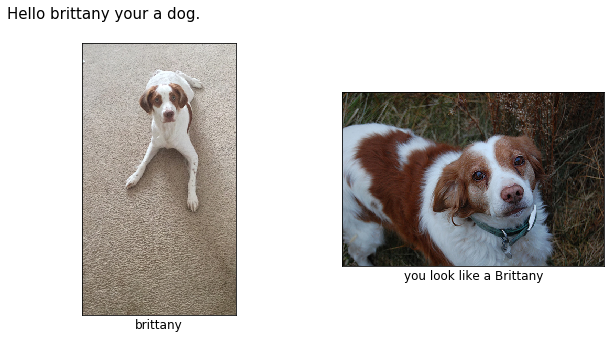

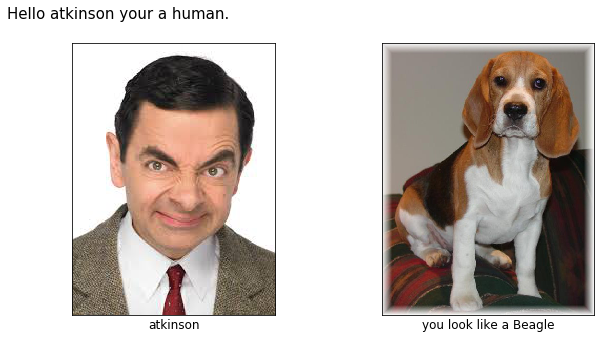

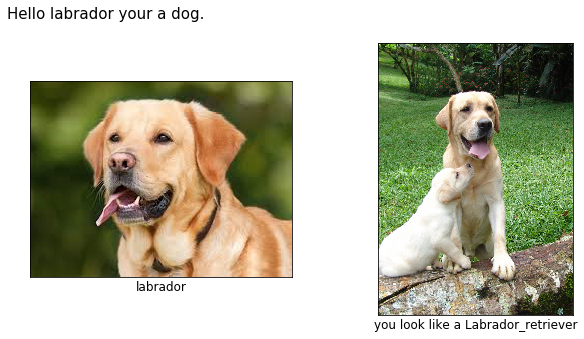

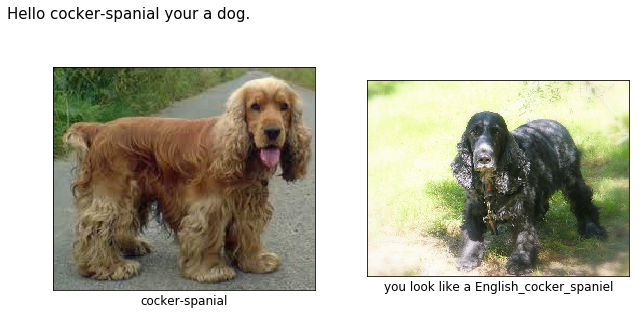

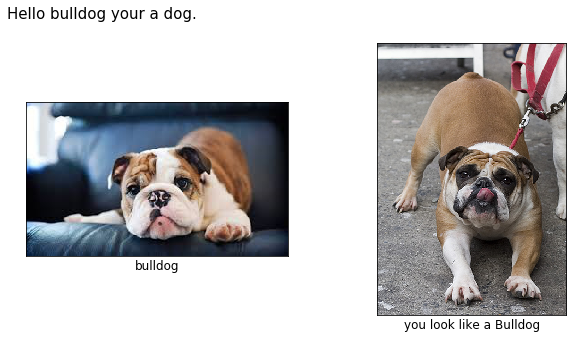

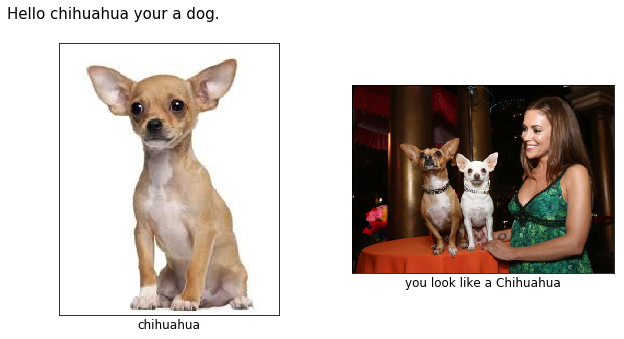

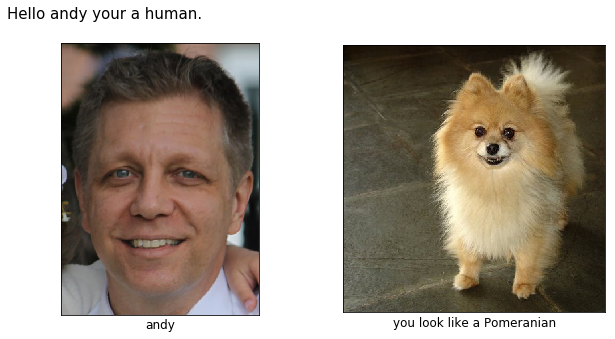

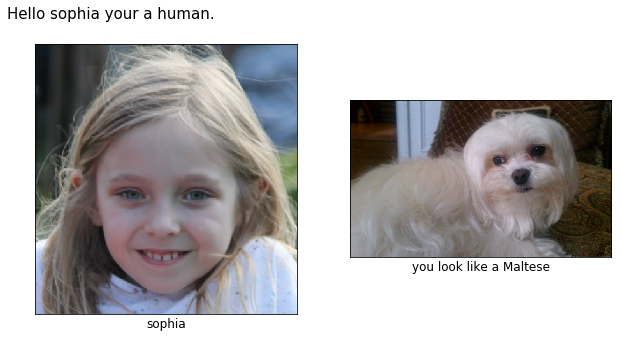

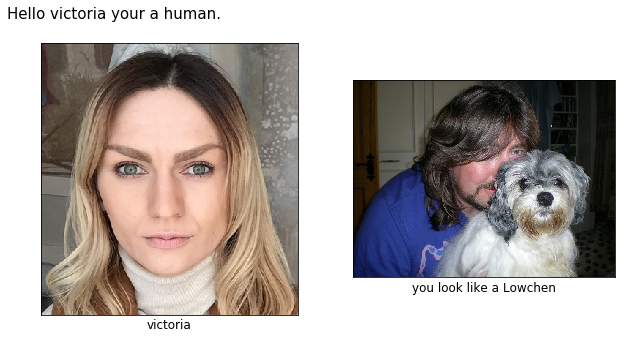

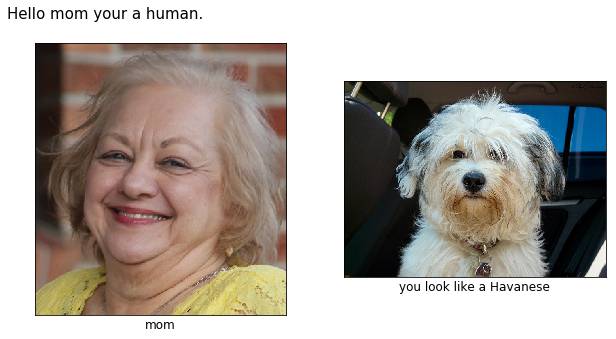

In [69]:
## TODO: Execute your algorithm from Step 6 on
## at least 6 images on your computer.
## Feel free to use as many code cells as needed.
human_or_dog('./our_brittany.jpg',"brittany")
human_or_dog('./myimages/atkinson.jpg',"atkinson")
human_or_dog('./myimages/lab.jpg',"labrador")
human_or_dog('./myimages/cocker_spanial.jpg',"cocker-spanial")
human_or_dog('./myimages/bulldog.jpg',"bulldog")
human_or_dog('./myimages/chihuahua.jpg',"chihuahua")
human_or_dog('./myimages/me.jpg',"andy")
human_or_dog('./myimages/sophia.jpg',"sophia")
human_or_dog('./myimages/wife.jpg',"victoria")
human_or_dog('./myimages/mom.jpg',"mom")

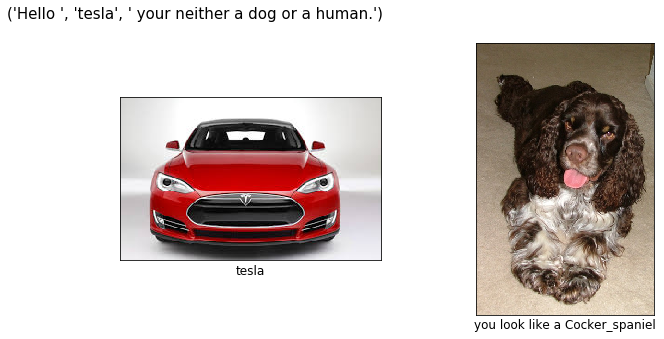

In [66]:
human_or_dog('./myimages/tesla.jpg','tesla')